In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pybamm
import pickle
import os
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [2]:
# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

temp_list = list(discharge_data.keys())

In [3]:
# Here I am not going to work with changing the initial conditions the gradient descent
# so this is taking the ICs for granted 
Ms = 32
n4 = 4
F = 9.649e4
S8_initial = 2.6730
ns8 = 8
S4_initial = 0.0128
ns4 = 4
cth = ((3 * n4 * F * S8_initial / (ns8 * Ms)) + (n4 * F * S4_initial / (ns4 * Ms))) / 3600

# define the initial values in grams of various species
S8_initial_g = 2.6730
S4_initial_g = 0.0128
S2_initial_g = 4.3321e-6
S1_initial_g = 1.6321e-6
Sp_initial_g = 2.7e-06

# the total active material mass
m_s = S8_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168

# define the current for later simulations
current = 0.0211*2

# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

S8_initial_hunt = S8_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.4

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt, 
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

In [7]:
def discharge_function(inputs):
    
    fitted_params_dict, temp = inputs
    
    current = 2*0.0211 # .2C discharge
    model = pybamm.lithium_sulfur.MarinescuEtAl2016_ks_temp()
    
    # non-fitted parameters
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Ambient Temperature [K]": temp,
        "Initial Condition for Terminal Voltage [V]": V_initial_hunt,
        "Initial Condition for S8 ion [g]": S8_initial_hunt,
        "Initial Condition for S4 ion [g]": S4_initial_hunt ,
        "Initial Condition for S2 ion [g]": S2_initial_hunt,
        "Initial Condition for S ion [g]": S1_initial_hunt,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial_hunt,
        "Mass of active sulfur per cell [g]": m_s_hunt,
        "Lower voltage cut-off [V]": 2.0,
        }
    )
    # fitted parameters (which are initial species values and initial voltage)
    params.update(fitted_params_dict)
    
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10/2
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [3,4,5,6]:
        print("trying number of time steps %f" %10**j)
        print("parameters are {}".format(fitted_params_dict))
        try:
            # simulate
            sim.solve(np.linspace(0, time_in_seconds,10**j))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries

            data = {'time' : t, 
                    'capacity' : Ah, 
                    'voltage' : V, 
                    'S8' : S8, 
                    'S4' : S4, 
                    'S2' : S2, 
                    'S1' : S1, 
                    'Sp' : Sp, 
                   } 
            return data
            
            break
        except:
            pass

In [8]:
# Here we will perform the charge fitting
def quick_norm(gradient):
    values = np.array(list(gradient.values()))
    return sum(values*values)

def gradient_descent_step(inputs,exp_capacity,exp_voltage,down_sampled_sim_voltage):
    fitted_params_dict, temp = inputs
    # create steps for each parameter to fit
    individually_stepped_params = []
    
    epsilon = 0.01
    for key in fitted_params_dict.keys():
        individually_stepped_params_dict = fitted_params_dict
        #print('Initial Dictionary')
        #print(individually_stepped_params_dict)
        individually_stepped_params_dict[key] = fitted_params_dict[key]*(1+epsilon)
        #print('Updated Dictionary')
        #print(individually_stepped_params_dict)
        individually_stepped_params.append(individually_stepped_params_dict)
    #print('\n\n\n')
    #print(individually_stepped_params)
    #print('\n\n\n')
    
    # run new simulations with individually stepped parameters
    individually_stepped_inputs = []
    for param_dict in individually_stepped_params:
        individually_stepped_inputs.append([param_dict, temp])
    
    #print('\n\n\n')
    #print('Performing Parallel Simulations')
    #print('\n\n\n')
    individually_stepped_sims = Parallel(n_jobs=-1)(delayed(discharge_function)(inputs) for inputs in individually_stepped_inputs)
    #print('\n\n\n')
    #print('Finished Performing Parallel Simulations')
    #print('\n\n\n')
    # downsample each sim to be able to subtract from base_sim for numerical derivative
    gradient = {}
    for i in range(0,len(individually_stepped_sims)):
        
        key = list(fitted_params_dict.keys())[i]
        sim = individually_stepped_sims[i]
        # at this point we're hoping there isn't a substantial difference in capacity due to parameter changes

        # down sample simulated voltage for comparison with experimental 
        temp_sim_V = np.interp(exp_capacity, sim['capacity'], sim['voltage'])
        voltage_partial_deriv_data =  (temp_sim_V-down_sampled_sim_voltage)/epsilon
        voltage_cost = sum( (down_sampled_sim_voltage - exp_voltage)*voltage_partial_deriv_data )*2/len(exp_voltage)
        #print(voltage_cost)
        mass_conservation_cost = (1e2)*2*(sim['S8'][0]+sim['S4'][0]+sim['S2'][0]+sim['S1'][0]+sim['Sp'][0] - .168)
        print(mass_conservation_cost/(2e3))
        #print(mass_conservation_cost)
        #print(key != 'voltage')
        alpha = 1
        beta = 1e3
        if key != 'Initial Condition for Terminal Voltage [V]':
            if key[-7:] =='ion [g]':
                if key[-9] == 'S':
                    species = sim['S1'][0]
                    non_zero_cost = -alpha*beta*np.exp(-beta*species)/(1+np.exp(-beta*species))**2
                elif key[-10] == 'S':
                    species = sim[key[-10:-8]][0]
                    non_zero_cost = -alpha*beta*np.exp(-beta*species)/(1+np.exp(-beta*species))**2
            elif key == "Initial Condition for Precipitated Sulfur [g]":
                species = sim['Sp'][0]
                non_zero_cost = -alpha*beta*np.exp(-beta*species)/(1+np.exp(-beta*species))**2
            #print(non_zero_cost)
            else:
                non_zero_cost = 0
            gradient[key] = voltage_cost+mass_conservation_cost+non_zero_cost
        else:
            gradient[key] = voltage_cost
        #print(key)
        #print('Voltage Cost = ' + str(voltage_cost))
        #print('Mass Conservation Cost = ' + str(mass_conservation_cost))
        #print('Zero Species Value Cost = '+ str(non_zero_cost))
        #print('\n \n')
    #print('The gradient is:')
    #print(gradient)
    
    # perform parameter update
    lam = 1e-7
    #print('Gradient norm = ' + str(quick_norm(gradient)))
    updated_params_dict = {}
    for key in fitted_params_dict:
        updated_params_dict[key] = fitted_params_dict[key] - lam*(gradient[key] +  np.random.rand(1)[0])
    print('The updated parameters are:')
    for item in updated_params_dict:
        print(item)
        print(updated_params_dict[item])
    
    return updated_params_dict, gradient
    
    

def down_sampled_sim_voltage_func(Ah, V, exp_capacity, exp_voltage):

    # check if simulation stops short of experimental capacity and adjust
    #if Ah[-1] < exp_capacity[-1]:
    #    temp_exp_capacity = exp_capacity[exp_capacity <= Ah[-1]]
    #else:
    #    temp_exp_capacity = exp_capacity
    # down sample simulated voltage for comparison with experimental 
    down_sampled_sim_voltage = np.interp(exp_capacity, Ah, V)
    
    return down_sampled_sim_voltage

def gradient_descent_proceedure(all_sims, all_params, temp):
    # get experimental data
    exp_capacity = discharge_data['30']['capacity']
    exp_voltage = discharge_data['30']['internal voltage'][0:len(exp_capacity)]
    
    # get new parameters
    params = all_params[-1]
    
    # get simulation data
    t, Ah, V, S8, S4, S2, S1, Sp = all_sims[-1].values()
    
    # get down-sampled sim voltage
    down_sampled_sim_voltage = down_sampled_sim_voltage_func(Ah, V,exp_capacity, exp_voltage)
    gradient_norms = []
    condition = True
    while condition:
        inputs = all_params[-1], temp
        
        # perform gradient descent step from latest simulation & parameters
        print('\n\n Performing Gradient Descent Step \n\n')
        try:
            updated_params, gradient = gradient_descent_step(inputs,exp_capacity,exp_voltage,down_sampled_sim_voltage)
            gradient_norms.append(quick_norm(gradient))
            # update parameter data
            all_params.append(updated_params)

            # perform simulation with new parameters
            inputs = all_params[-1], temp
            print('\n\n Performing New Simulation \n\n')
            new_base_sim = discharge_function(inputs)

            # down-sample sim data to experimental data
            t, Ah, V, S8, S4, S2, S1, Sp = new_base_sim.values()
            down_sampled_sim_voltage = down_sampled_sim_voltage_func(Ah, V,exp_capacity, exp_voltage)

            # update simulation data set
            all_sims.append(new_base_sim)
        except:
            condition = False
        if quick_norm(gradient)<gradient_norms[0]*1e-3:
            condition = False
        if len(all_sims) > 50:
            condition = False
            
    return all_sims, all_params

In [9]:
temp_k = 272.15 + 30
fitted_params = {'S saturation mass [g]': 0.0001,
                'Precipitation rate [s-1]': 100}
inputs = fitted_params, temp_k
base_discharge_sim = discharge_function(inputs)

Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'S saturation mass [g]': 0.0001, 'Precipitation rate [s-1]': 100}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

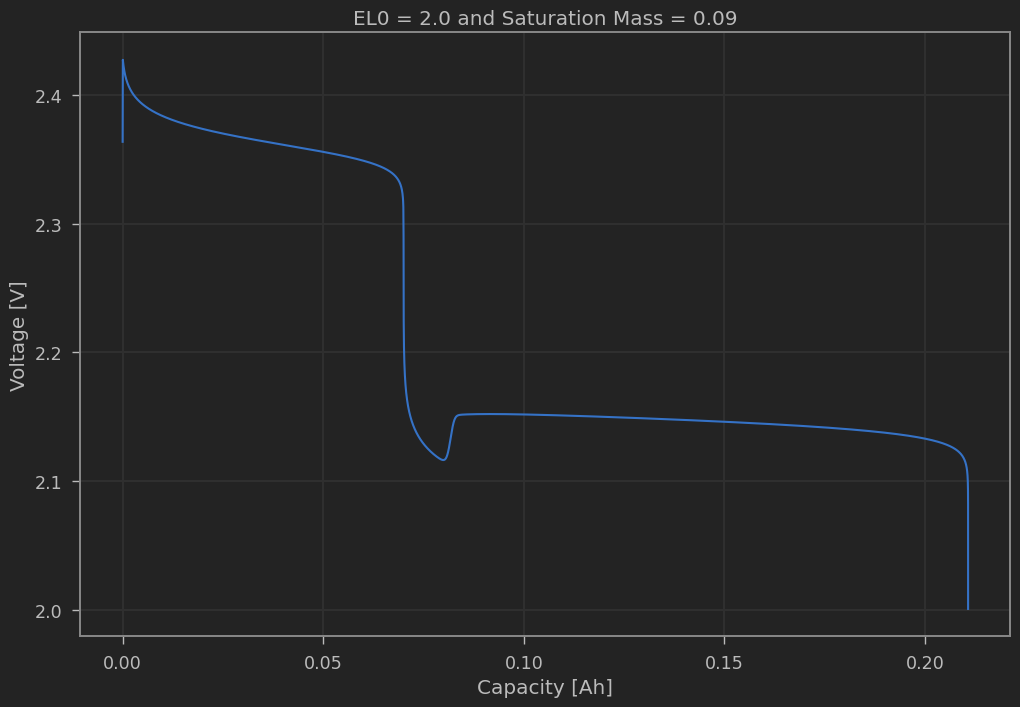

In [10]:
plt.plot(base_discharge_sim['capacity'],base_discharge_sim['voltage'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('EL0 = 2.0 and Saturation Mass = 0.09')
plt.grid(True)
notify

Starting temperature 292.150000
trying number of time steps 1000.000000
parameters are {'S saturation mass [g]': 0.09}
trying number of time steps 10000.000000
parameters are {'S saturation mass [g]': 0.09}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'S saturation mass [g]': 0.09}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 312.150000
trying number of time steps 1000.000000
parameters are {'S saturation mass [g]': 0.09}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

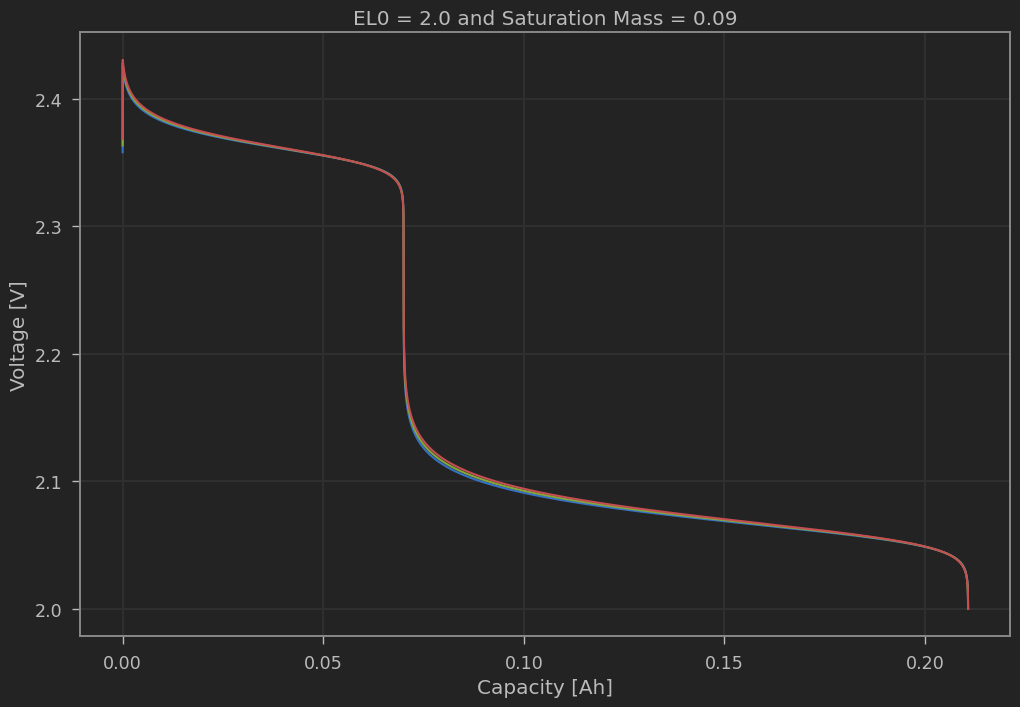

In [11]:
 for temp in [20,30,40]:
    temp_k = 272.15 + temp
    fitted_params = {'S saturation mass [g]': 0.09,}
    inputs = fitted_params, temp_k
    base_discharge_sim = discharge_function(inputs)
    plt.plot(base_discharge_sim['capacity'],base_discharge_sim['voltage'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('EL0 = 2.0 and Saturation Mass = 0.09')
plt.grid(True)
notify

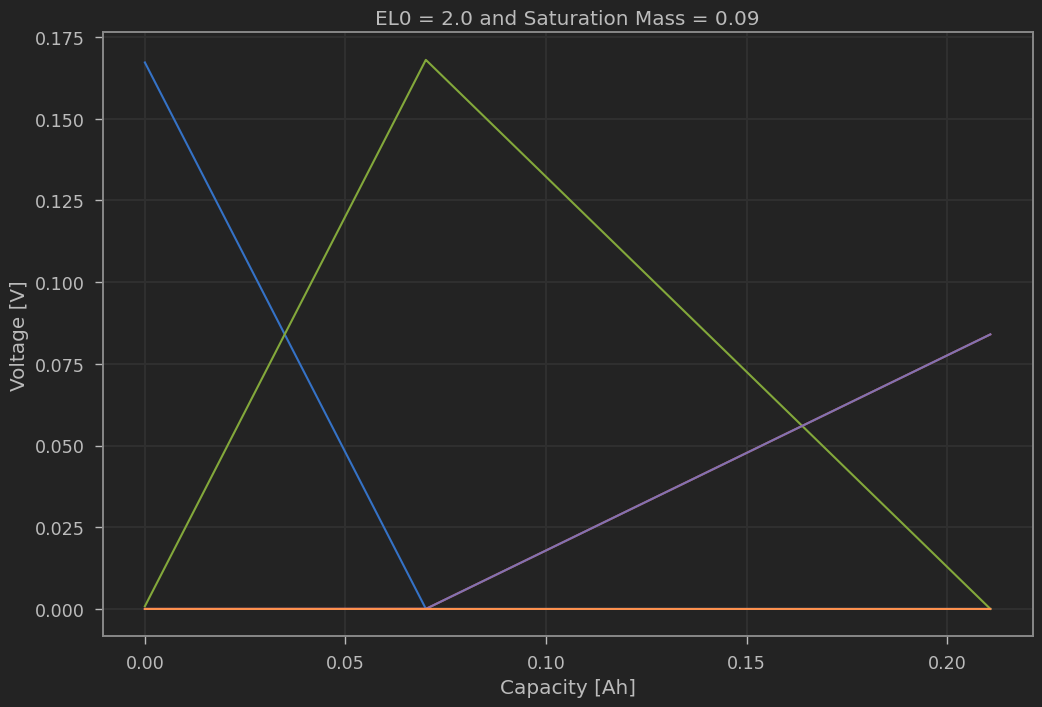

In [15]:

plt.plot(base_discharge_sim['capacity'],base_discharge_sim['S8'])
plt.plot(base_discharge_sim['capacity'],base_discharge_sim['S4'])
plt.plot(base_discharge_sim['capacity'],base_discharge_sim['S2'])
plt.plot(base_discharge_sim['capacity'],base_discharge_sim['S1'])
plt.plot(base_discharge_sim['capacity'],base_discharge_sim['Sp'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('EL0 = 2.0 and Saturation Mass = 0.09')
plt.grid(True)
notify

In [9]:
'''
all_params = [fitted_params]
temp_k = 272.15 + 30
all_sims = [base_discharge_sim]
all_sims, all_params = gradient_descent_proceedure(all_sims, all_params, temp_k)
'''

'\nall_params = [fitted_params]\ntemp_k = 272.15 + 30\nall_sims = [base_discharge_sim]\nall_sims, all_params = gradient_descent_proceedure(all_sims, all_params, temp_k)\n'

In [10]:
'''
for sims in all_sims:
    plt.plot(sims['capacity'],sims['voltage'])

legend = []
for params_dict in all_params:
    legend.append(params_dict['S saturation mass [g]'])
plt.legend(legend)
'''

"\nfor sims in all_sims:\n    plt.plot(sims['capacity'],sims['voltage'])\n\nlegend = []\nfor params_dict in all_params:\n    legend.append(params_dict['S saturation mass [g]'])\nplt.legend(legend)\n"

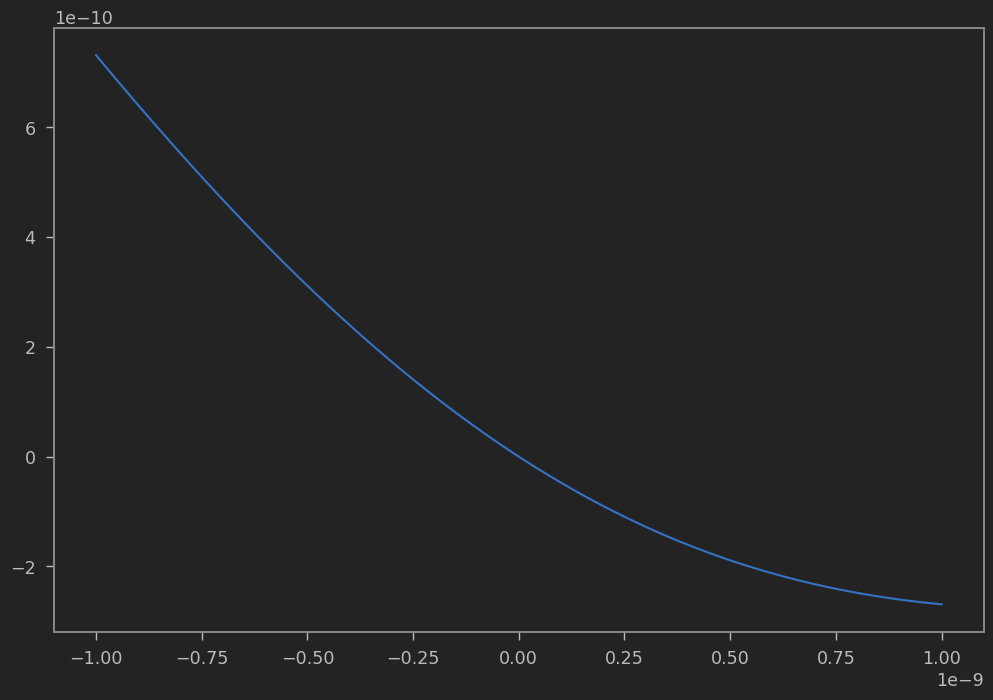

In [111]:
x = np.linspace(-1e-9,1e-9,10000)
ep = 1e-15
gamma = 1
beta = 1e9
y = -gamma*(x-ep)/(1 + np.exp(beta * x))
plt.plot(x,y)

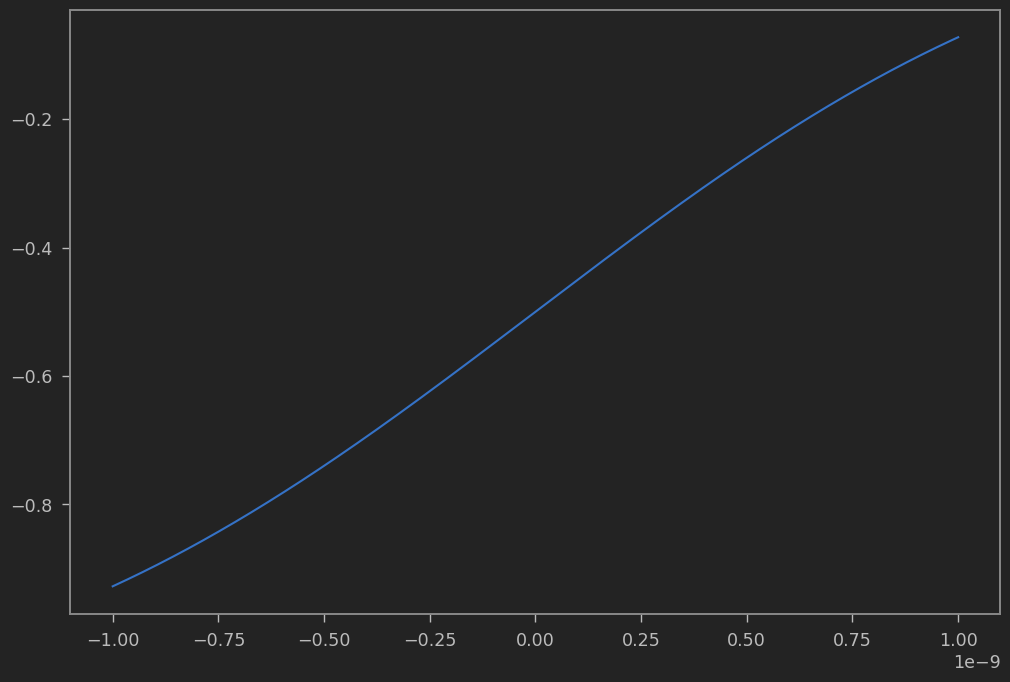

In [112]:

y  = -gamma * (1 + (1-beta*(x-ep))*np.exp(beta*x) ) / ((1+np.exp(beta*x))**2)
plt.plot(x,y)


In [106]:
y

array([-1., -1., -1., ..., nan, nan, nan])